<a href="https://colab.research.google.com/github/thaisflopes/projeto_de_pesquisa_judicializacao_transporte_aereo/blob/main/Meta_A05_Modelo_SVM_dano_moral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Bibliotecas
import pandas as pd
import numpy as np
import time
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Início da contagem de tempo
inicio = time.time()

### Baixando bases de dados

In [ ]:
#Baixando dados pelo Google Drive
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/MyDrive/Projeto de pesquisa/Base_Dados/Códigos Finais - Aprendizado de Máquina/dados_modelos_ind_cat.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Baixando dados pelo Anaconda
#data = pd.read_csv('dados_modelos_ind_cat.csv')

In [ ]:
#Visualizando dados
print('\n Visualização do DataFrame:\n', data.head())
print('\n Tipos de dados do DataFrame:\n', data.dtypes)


 Visualização do DataFrame:
   empresa_re  num_proc_ano   operacao              jurisdicao     instancia  \
0       Azul          2020  Doméstico  Juizado Especial Cível  1ª Instância   
1       Azul          2019  Doméstico  Juizado Especial Cível  1ª Instância   
2       Azul          2020  Doméstico  Juizado Especial Cível  2ª Instância   
3       Azul          2022  Doméstico  Juizado Especial Cível  1ª Instância   
4       Azul          2021  Doméstico  Juizado Especial Cível  1ª Instância   

  situacao_processual_sentenca  n_autores  obj_problemas_operacionais  \
0                   Condenação          1                        True   
1                   Condenação          2                        True   
2                   Condenação          1                        True   
3                   Condenação          1                        True   
4                   Condenação          1                        True   

   obj_bagagem  obj_contrato  ...  causa_forca_maior  ca

In [ ]:
# Verificando a distribuição da classe
print(data['valor_dano_moral_novo'].value_counts())

valor_dano_moral_novo
Baixo    69298
Médio    38662
Alto     18076
Name: count, dtype: int64


### Preparando inputs e output

In [ ]:
#Separando inputs e output
X = data.drop(['valor_dano_moral_novo'], axis=1)
y = data['valor_dano_moral_novo']

### Transformando dados categóricos para numéricos

#### X

In [ ]:
# Dividindo as variáveis numéricas e categóricas
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(exclude=['object']).columns

In [ ]:
# Definindo as transformações
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns), # Transformando as colunas categóricas por OneHotEncoder
        ('num', MinMaxScaler(), numeric_columns)  # Escalando as variáveis numéricas para o intervalo [0, 1]
    ])

In [ ]:
# Aplicando as transformações
X_ajustado = preprocessor.fit_transform(X)
print('\nAtributos codificados:\n', X_ajustado)


Atributos codificados:
 [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### y

In [ ]:
#Transformando a classe a ser predita por LabelEncoder

#Definindo a ordem desejada
le = LabelEncoder()
le.fit(['Baixo', 'Médio', 'Alto'])

#Transformando as classes
y_ajustado = le.transform(y)
print('\nClasses encoded:\n', y_ajustado)


Classes encoded:
 [1 1 1 ... 0 2 2]


### Dividindo dados de treino e teste

In [ ]:
#Usamos train_test_split com a opção stratify=y para garantir que cada conjunto (treino e teste) mantenha a proporção das categorias.
X_train, X_test, y_train, y_test = train_test_split(X_ajustado, y_ajustado, test_size=0.2, stratify=y_ajustado, random_state=42)

In [ ]:
#Verificando tamanho das bases
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((100828, 40), (25208, 40), (100828,), (25208,))

### Modelo SVM

In [ ]:
#Instanciando o modelo
svm_linearSVC = LinearSVC(dual=True, max_iter=500000, random_state=42, C=2, penalty='l2', loss='hinge')

In [ ]:
# Transformando y_train em um DataFrame para utilizar value_counts
y_train_df = pd.Series(y_train)

# Exibindo a distribuição de classes
print(y_train_df.value_counts())

1    55438
2    30929
0    14461
Name: count, dtype: int64


#### Com balanceamento dos dados

In [ ]:
# Aplicando undersampling aos dados de treino
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [ ]:
#Verificando tamanho das bases
X_train_resampled.shape, y_train_resampled.shape

((43383, 40), (43383,))

In [ ]:
# Transformando y_train_resampled em um DataFrame para utilizar value_counts
y_train_resampled_df = pd.Series(y_train_resampled)

# Exibindo a distribuição de classes
print(y_train_resampled_df.value_counts())

0    14461
1    14461
2    14461
Name: count, dtype: int64


In [ ]:
#Treinando o modelo
svm_linearSVC.fit(X_train_resampled, y_train_resampled)

LinearSVC(C=2, dual=True, loss='hinge', max_iter=500000, random_state=42)

In [ ]:
#Calibrar o modelo para obter probabilidades
svm_calibrated = CalibratedClassifierCV(svm_linearSVC, cv='prefit')
svm_calibrated.fit(X_train_resampled, y_train_resampled)

CalibratedClassifierCV(cv='prefit',
                       estimator=LinearSVC(C=2, dual=True, loss='hinge',
                                           max_iter=500000, random_state=42))

In [ ]:
#Avaliar modelo
y_pred = svm_calibrated.predict(X_test)
y_proba = svm_calibrated.predict_proba(X_test)
precisao_ponderada = precision_score(y_test, y_pred, average='weighted')
acuracia = accuracy_score(y_test, y_pred)
recall_ponderado = recall_score(y_test, y_pred, average='weighted')
f1score_ponderado = f1_score(y_test, y_pred, average='weighted')
auc_roc = roc_auc_score(y_test, y_proba, multi_class='ovo')
conf_mat = confusion_matrix(y_test, y_pred)

In [ ]:
# Exibir resultados
print(f'Precisão ponderada: {precisao_ponderada:.4f}')
print(f'Acurácia: {acuracia:.4f}')
print(f'Recall ponderado: {recall_ponderado:.4f}')
print(f'F1-score: {f1score_ponderado:.4f}')
print(f'AUC_ROC: {auc_roc:.4f}')
print('Confusion Matrix:')
print(conf_mat)

Precisão ponderada: 0.7335
Acurácia: 0.7056
Recall ponderado: 0.7056
F1-score: 0.7158
AUC_ROC: 0.8302
Confusion Matrix:
[[ 2160   411  1044]
 [ 1133 10853  1874]
 [ 1870  1088  4775]]


##### Importância das Variáveis - Permutation Importance

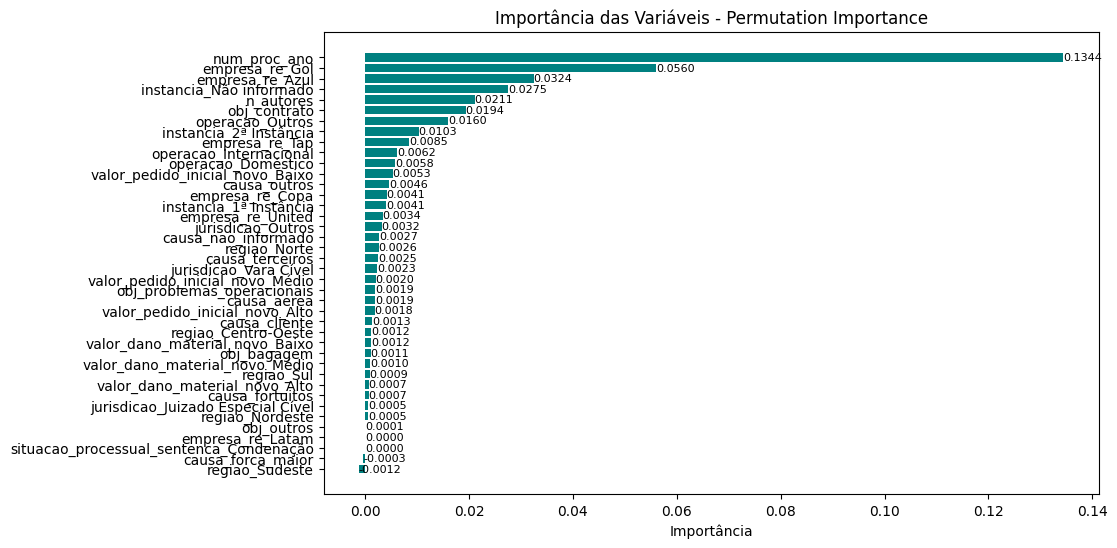

In [ ]:
# Calculando a importância das variáveis com permutation importance
result = permutation_importance(svm_calibrated, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Importâncias das variáveis
importance = result.importances_mean

# Criando um gráfico para visualizar as importâncias das variáveis
features = preprocessor.transformers_[0][1].get_feature_names_out(categorical_columns).tolist() + numeric_columns.tolist()

# Ordenando as importâncias
indices = np.argsort(importance)[::-1]

# Plotando as importâncias
plt.figure(figsize=(10, 6))
bars = plt.barh(np.array(features)[indices], importance[indices], color='teal')

# Adicionando os valores no final de cada barra
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.4f}',  # Exibe o valor com 2 casas decimais
             va='center', ha='left', fontsize=8, color='black')

plt.xlabel('Importância')
plt.title('Importância das Variáveis - Permutation Importance')
plt.gca().invert_yaxis()  # Inverter para mostrar a mais importante no topo
plt.show()

##### Correlação das variáveis

In [ ]:
#Convertendo X_test para DataFrame
column_names = preprocessor.transformers_[0][1].get_feature_names_out(categorical_columns).tolist() + numeric_columns.tolist()
X_test_df = pd.DataFrame(X_test, columns=column_names)

# Calculando a correlação entre as variáveis de X_test
correlacao = X_test_df.corr()

# Criando uma lista de tuplas com as variáveis e suas correlações
variaveis_correlacionadas = []

# Iterando sobre a matriz de correlação e extraindo os pares de variáveis e seus valores de correlação
for i in range(len(correlacao.columns)):
    for j in range(i):
        if i != j:  # Não incluir a correlação de uma variável consigo mesma
            variaveis_correlacionadas.append((correlacao.columns[i], correlacao.columns[j], correlacao.iloc[i, j]))

# Criando um DataFrame com os pares de variáveis e suas correlações
df_correlacao = pd.DataFrame(variaveis_correlacionadas, columns=['Variável 1', 'Variável 2', 'Correlação'])

# Ordenando a tabela pela correlação de forma decrescente (do maior para o menor valor absoluto)
df_correlacao['Correlação'] = df_correlacao['Correlação'].abs()  # Usar o valor absoluto para ordenação
df_correlacao_sorted = df_correlacao.sort_values(by='Correlação', ascending=False)

# Exibindo a tabela ordenada
print("\nCorrelação das variáveis:")
df_correlacao_sorted


Correlação das variáveis:


,Variável 1,Variável 2,Correlação
528,causa_nao_informado,empresa_re_Azul,0.938022
64,jurisdicao_Vara Cível,jurisdicao_Juizado Especial Cível,0.905471
350,valor_dano_material_novo_Médio,valor_dano_material_novo_Baixo,0.796130
1,empresa_re_Gol,empresa_re_Azul,0.778577
103,instancia_Não informado,instancia_1ª Instância,0.740919
...,...,...,...
681,causa_cliente,situacao_processual_sentenca_Condenação,NaN
706,causa_aerea,empresa_re_Latam,NaN
718,causa_aerea,situacao_processual_sentenca_Condenação,NaN
744,causa_outros,empresa_re_Latam,NaN


In [ ]:
# Exibindo as correlações mais altas (> 0.5 ou <-0.5)
limiar_correlacao = 0.5
variaveis_correlacionadas_altas = []

for i in range(len(correlacao.columns)):
    for j in range(i):
        if abs(correlacao.iloc[i, j]) > limiar_correlacao:
            variaveis_correlacionadas_altas.append((correlacao.columns[i], correlacao.columns[j], correlacao.iloc[i, j]))

# Criando um DataFrame com as variáveis mais correlacionadas
df_correlacao_alta = pd.DataFrame(variaveis_correlacionadas_altas, columns=['Variável 1', 'Variável 2', 'Correlação'])

# Ordenando a tabela pela correlação de forma decrescente (do maior para o menor valor absoluto)
df_correlacao_alta['Correlação'] = df_correlacao_alta['Correlação'].abs()  # Usar o valor absoluto para ordenação
df_correlacao_alta_sorted = df_correlacao_alta.sort_values(by='Correlação', ascending=False)

# Exibindo a tabela ordenada
print("\nVariáveis com Correlação Alta (Maior que 0.5 ou menor que -0.5):")
df_correlacao_alta_sorted


Variáveis com Correlação Alta (Maior que 0.5 ou menor que -0.5):


,Variável 1,Variável 2,Correlação
15,causa_nao_informado,empresa_re_Azul,0.938022
7,jurisdicao_Vara Cível,jurisdicao_Juizado Especial Cível,0.905471
13,valor_dano_material_novo_Médio,valor_dano_material_novo_Baixo,0.796130
0,empresa_re_Gol,empresa_re_Azul,0.778577
9,instancia_Não informado,instancia_1ª Instância,0.740919
16,causa_nao_informado,empresa_re_Gol,0.730323
5,operacao_Outros,empresa_re_Gol,0.714924
6,operacao_Outros,operacao_Doméstico,0.680422
20,causa_fortuitos,empresa_re_United,0.670907
19,causa_nao_informado,instancia_Não informado,0.649546


In [ ]:
# Salvando correlaçãoes
df_correlacao_alta_sorted.to_excel('correlacao_svm.xlsx', index=False)

In [ ]:
#Fim da contagem de tempo
fim = time.time()
print('\n Tempo de processamento (min):', (fim - inicio)/60)


 Tempo de processamento (min): 0.7735039313634237
